In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F


seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

d_in = 5
d_out = 5
train_size = 100
test_size = 100
w = 100

class Net(nn.Module):

    def __init__(self, w=w):
        super(Net, self).__init__()
        self.l1 = nn.Linear(d_in, w)
        self.l2 = nn.Linear(w, w)
        self.l3 = nn.Linear(w,d_out)

    def forward(self, x):
        f = torch.nn.Tanh()
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        return self.x3
    
teacher = Net()
inputs_train = torch.tensor(torch.normal(0,1,size=(train_size, d_in)), dtype=torch.float, requires_grad=True)
labels_train = torch.tensor(teacher(inputs_train), dtype=torch.float, requires_grad=True)

inputs_test = torch.normal(0,1,size=(test_size, d_in))
labels_test = teacher(inputs_test)

/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_32309/121145993.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_train = torch.tensor(torch.normal(0,1,size=(train_size, d_in)), dtype=torch.float, requires_grad=True)
/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_32309/121145993.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(teacher(inputs_train), dtype=torch.float, requires_grad=True)


In [12]:
def L2(model):
    params = list(model.parameters())
    l2 = 0
    for i in range(6):
        if i == 0:
            params_flatten = params[i].reshape(-1,)
        params_flatten = torch.cat([params_flatten, params[i].reshape(-1,)])
    l2 = torch.sum(params_flatten**2)
    return params_flatten, l2

def init(model, alpha):
    state_dict = model.state_dict()
    modules = ["l1.weight", "l1.bias", "l2.weight", "l2.bias", "l3.weight", "l3.bias"]
    for module in modules:
        state_dict[module] = state_dict[module] * alpha
    model.load_state_dict(state_dict)
    
def init2(model, alpha):
    model.l1.weight.data = model.l1.weight * alpha
    model.l1.bias.data = model.l1.bias * alpha
    model.l2.weight.data = model.l2.weight * alpha
    model.l2.bias.data = model.l2.bias * alpha
    model.l3.weight.data = model.l3.weight * alpha
    model.l3.bias.data = model.l3.bias * alpha

    
def grad(model):
    grads = list(student.parameters())
    for i in range(6):
        if i == 0:
            grad = grads[0].reshape(-1,)
        else:
            grad = torch.cat([grad, grads[i].reshape(-1,)])
    return grad
    
    
def func(a, b, c, d, e, f):
    p = [a.view(w,d_in), b, c.view(w,w), d, e.view(d_out, w), f]
    
    f = torch.nn.Tanh()
    x1 = f(F.linear(inputs_train, p[0], p[1]))
    x2 = f(F.linear(x1, p[2], p[3]))
    out = F.linear(x2, p[4], p[5])
    
    loss = torch.mean((out-labels_train), dim=1)
    return loss


In [17]:
alphas = 10**torch.linspace(-1,1,steps=11)
loss_train_alpha = []
loss_test_alpha = []
Trs = []
l2_weights = []

for alpha in alphas:
    print("---------alpha={}---------".format(alpha))
    seed = 1
    np.random.seed(seed)
    torch.manual_seed(seed)
    student = Net()

    init(student, alpha=alpha)
    _, scale = L2(student)

    epochs = 10000
    log = 200

    optimizer = torch.optim.Adam(student.parameters(), lr=3e-4)

    losses_train = []
    losses_test = []
    l2s = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        optimizer.zero_grad()

        outputs_train = student(inputs_train)
        loss_train = torch.mean((outputs_train-labels_train)**2)
        outputs_test = student(inputs_test)
        loss_test = torch.mean((outputs_test-labels_test)**2)
        params, l2 = L2(student)
        init2(student, alpha=torch.sqrt(scale/l2))
        params, l2 = L2(student)

        loss_train.backward()

        optimizer.step()

        if epoch % log == 0:
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | l2: %.6f"%(epoch, loss_train.detach().numpy(), loss_test.detach().numpy(), l2.detach().numpy()))

        losses_train.append(loss_train.detach().numpy())
        losses_test.append(loss_test.detach().numpy())
        l2s.append(l2.detach().numpy())
        
    loss_train_alpha.append(loss_train.detach().numpy())
    loss_test_alpha.append(loss_test.detach().numpy())
    
    h = torch.autograd.functional.jacobian(func, tuple([_.view(-1) for _ in student.parameters()]))
    for i in range(6):
        if i == 0:
            h_ = h[0]
        else:
            h_ = torch.cat([h_, h[i]], dim=1)

    svs = torch.svd(h_).S.detach().numpy()
    trJtJ = np.sum(svs**2)
    Trs.append(trJtJ)
    l2_weights.append(l2.detach().numpy())
    

---------alpha=0.10000000149011612---------
epoch: 0  | Train loss: 0.018496 |  Test loss: 0.018844 | l2: 1.073967
epoch: 200  | Train loss: 0.013599 |  Test loss: 0.016045 | l2: 1.073967
epoch: 400  | Train loss: 0.013694 |  Test loss: 0.016092 | l2: 1.073967
epoch: 600  | Train loss: 0.013755 |  Test loss: 0.016153 | l2: 1.073967
epoch: 800  | Train loss: 0.013798 |  Test loss: 0.016118 | l2: 1.073967
epoch: 1000  | Train loss: 0.013849 |  Test loss: 0.016147 | l2: 1.073967
epoch: 1200  | Train loss: 0.013894 |  Test loss: 0.016227 | l2: 1.073967
epoch: 1400  | Train loss: 0.013922 |  Test loss: 0.016265 | l2: 1.073967
epoch: 1600  | Train loss: 0.013912 |  Test loss: 0.016215 | l2: 1.073967
epoch: 1800  | Train loss: 0.013911 |  Test loss: 0.016158 | l2: 1.073967
epoch: 2000  | Train loss: 0.013945 |  Test loss: 0.016213 | l2: 1.073967
epoch: 2200  | Train loss: 0.013988 |  Test loss: 0.016325 | l2: 1.073967
epoch: 2400  | Train loss: 0.014011 |  Test loss: 0.016361 | l2: 1.073967
e

epoch: 2000  | Train loss: 0.000600 |  Test loss: 0.000847 | l2: 6.776275
epoch: 2200  | Train loss: 0.000608 |  Test loss: 0.000854 | l2: 6.776274
epoch: 2400  | Train loss: 0.000606 |  Test loss: 0.000855 | l2: 6.776275
epoch: 2600  | Train loss: 0.000630 |  Test loss: 0.000878 | l2: 6.776275
epoch: 2800  | Train loss: 0.000630 |  Test loss: 0.000883 | l2: 6.776274
epoch: 3000  | Train loss: 0.000632 |  Test loss: 0.000886 | l2: 6.776275
epoch: 3200  | Train loss: 0.000649 |  Test loss: 0.000898 | l2: 6.776274
epoch: 3400  | Train loss: 0.000642 |  Test loss: 0.000895 | l2: 6.776275
epoch: 3600  | Train loss: 0.000641 |  Test loss: 0.000897 | l2: 6.776275
epoch: 3800  | Train loss: 0.000670 |  Test loss: 0.000930 | l2: 6.776275
epoch: 4000  | Train loss: 0.000692 |  Test loss: 0.000963 | l2: 6.776275
epoch: 4200  | Train loss: 0.000713 |  Test loss: 0.000990 | l2: 6.776274
epoch: 4400  | Train loss: 0.000725 |  Test loss: 0.001017 | l2: 6.776275
epoch: 4600  | Train loss: 0.000756 | 

epoch: 3800  | Train loss: 0.000005 |  Test loss: 0.000112 | l2: 42.755413
epoch: 4000  | Train loss: 0.000005 |  Test loss: 0.000110 | l2: 42.755405
epoch: 4200  | Train loss: 0.000004 |  Test loss: 0.000109 | l2: 42.755405
epoch: 4400  | Train loss: 0.000004 |  Test loss: 0.000108 | l2: 42.755409
epoch: 4600  | Train loss: 0.000003 |  Test loss: 0.000107 | l2: 42.755405
epoch: 4800  | Train loss: 0.000003 |  Test loss: 0.000106 | l2: 42.755409
epoch: 5000  | Train loss: 0.000003 |  Test loss: 0.000105 | l2: 42.755405
epoch: 5200  | Train loss: 0.000002 |  Test loss: 0.000104 | l2: 42.755409
epoch: 5400  | Train loss: 0.000002 |  Test loss: 0.000102 | l2: 42.755405
epoch: 5600  | Train loss: 0.000002 |  Test loss: 0.000101 | l2: 42.755402
epoch: 5800  | Train loss: 0.000002 |  Test loss: 0.000100 | l2: 42.755405
epoch: 6000  | Train loss: 0.000002 |  Test loss: 0.000098 | l2: 42.755417
epoch: 6200  | Train loss: 0.000002 |  Test loss: 0.000096 | l2: 42.755413
epoch: 6400  | Train loss

epoch: 5400  | Train loss: 0.000000 |  Test loss: 0.001493 | l2: 269.768341
epoch: 5600  | Train loss: 0.000000 |  Test loss: 0.001487 | l2: 269.768341
epoch: 5800  | Train loss: 0.000000 |  Test loss: 0.001486 | l2: 269.768311
epoch: 6000  | Train loss: 0.000000 |  Test loss: 0.001482 | l2: 269.768341
epoch: 6200  | Train loss: 0.000001 |  Test loss: 0.001482 | l2: 269.768311
epoch: 6400  | Train loss: 0.000004 |  Test loss: 0.001485 | l2: 269.768311
epoch: 6600  | Train loss: 0.000002 |  Test loss: 0.001475 | l2: 269.768341
epoch: 6800  | Train loss: 0.000001 |  Test loss: 0.001471 | l2: 269.768341
epoch: 7000  | Train loss: 0.000000 |  Test loss: 0.001472 | l2: 269.768311
epoch: 7200  | Train loss: 0.000000 |  Test loss: 0.001474 | l2: 269.768311
epoch: 7400  | Train loss: 0.000000 |  Test loss: 0.001473 | l2: 269.768280
epoch: 7600  | Train loss: 0.000000 |  Test loss: 0.001473 | l2: 269.768341
epoch: 7800  | Train loss: 0.000001 |  Test loss: 0.001471 | l2: 269.768311
epoch: 8000 

epoch: 6800  | Train loss: 0.000000 |  Test loss: 0.429575 | l2: 1702.123413
epoch: 7000  | Train loss: 0.000000 |  Test loss: 0.429575 | l2: 1702.123413
epoch: 7200  | Train loss: 0.000000 |  Test loss: 0.429575 | l2: 1702.123413
epoch: 7400  | Train loss: 0.000000 |  Test loss: 0.429575 | l2: 1702.123413
epoch: 7600  | Train loss: 0.000000 |  Test loss: 0.429575 | l2: 1702.123413
epoch: 7800  | Train loss: 0.000000 |  Test loss: 0.429519 | l2: 1702.123413
epoch: 8000  | Train loss: 0.000000 |  Test loss: 0.429518 | l2: 1702.123413
epoch: 8200  | Train loss: 0.000000 |  Test loss: 0.429518 | l2: 1702.123413
epoch: 8400  | Train loss: 0.000000 |  Test loss: 0.429518 | l2: 1702.123413
epoch: 8600  | Train loss: 0.000000 |  Test loss: 0.429518 | l2: 1702.123413
epoch: 8800  | Train loss: 0.000000 |  Test loss: 0.429518 | l2: 1702.123413
epoch: 9000  | Train loss: 0.000000 |  Test loss: 0.429469 | l2: 1702.123291
epoch: 9200  | Train loss: 0.000000 |  Test loss: 0.429469 | l2: 1702.123413

epoch: 8000  | Train loss: 0.000000 |  Test loss: 9.624020 | l2: 10739.671875
epoch: 8200  | Train loss: 0.000000 |  Test loss: 9.624020 | l2: 10739.671875
epoch: 8400  | Train loss: 0.000000 |  Test loss: 9.624020 | l2: 10739.671875
epoch: 8600  | Train loss: 0.000000 |  Test loss: 9.624019 | l2: 10739.671875
epoch: 8800  | Train loss: 0.000000 |  Test loss: 9.624020 | l2: 10739.671875
epoch: 9000  | Train loss: 0.000000 |  Test loss: 9.624020 | l2: 10739.671875
epoch: 9200  | Train loss: 0.000000 |  Test loss: 9.624020 | l2: 10739.671875
epoch: 9400  | Train loss: 0.000000 |  Test loss: 9.624020 | l2: 10739.671875
epoch: 9600  | Train loss: 0.000000 |  Test loss: 9.624020 | l2: 10739.671875
epoch: 9800  | Train loss: 0.000000 |  Test loss: 9.624020 | l2: 10739.671875


Text(0.5, 1.0, 'No regularization')

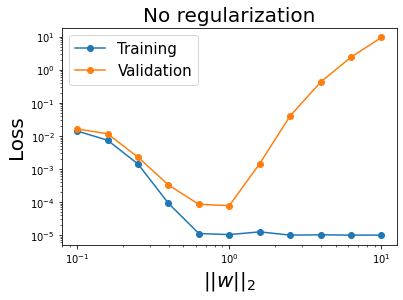

In [24]:
plt.plot(alphas, np.array(loss_train_alpha)+1e-5, marker="o")
plt.plot(alphas, loss_test_alpha, marker="o")
plt.yscale('log')
plt.xscale('log')

plt.legend(["Training", "Validation"], fontsize=15)
plt.xlabel(r"$||w||_2$", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("No regularization", fontsize=20)